In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from collections import defaultdict
from tqdm.auto import tqdm

import random
from sklearn.ensemble import RandomForestClassifier

import pandas_profiling
import warnings

from collections import Counter
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

In [2]:
tokamak_data = pd.read_pickle("./final.pkl")


In [3]:
skipped_columns = ["tok", "is_good", "standard" , "walmat_c"]

skipped_columns

['tok', 'is_good', 'standard', 'walmat_c']

In [4]:
tokamak_data.columns

Index(['_abs_bt_2', '_abs_bt_2_abs_ip', '_abs_bt_2_epsilon',
       '_abs_bt_2_inv_abs_ip', '_abs_bt_2_inv_epsilon', '_abs_bt_2_inv_nel',
       '_abs_bt_2_inv_pressure', '_abs_bt_2_inv_rgeo', '_abs_bt_2_inv_tev',
       '_abs_bt_2_inv_vol',
       ...
       'walmat_in', 'walmat_ss', 'wfaniic', 'wmhd', 'wth', 'wtot',
       'zero_delta', 'zero_log_tauc92', 'zero_log_tauc93', 'zero_wfaniic'],
      dtype='object', length=996)

In [5]:
cur_data = tokamak_data.copy()

desired_dict = {
    'JET': 3144,
    'ASDEX': 1250,
    'AUG': 1250,
    'CMOD': 750,
    'D3D': 1250,
    'JFT2M': 1000,
    'JT60U': 250,
    'TCV': 100,
    'TDEV': 75,
    'NSTX': 50,
    'PBXM': 500,
    'PDX': 500,
    'TFTR': 500
}

tok_dict = {}

for cur_key in desired_dict.keys():
    tok_dict[cur_key] = np.sum(tokamak_data.tok == cur_key)

for cur_key, cur_value in desired_dict.items():
    print(cur_key, cur_value / tok_dict[cur_key])

for cur_key, cur_value in desired_dict.items():
    in_rows = cur_data[cur_data.tok == cur_key].copy()
    in_count = len(in_rows)

    cur_data = cur_data.append(in_rows.sample(cur_value % in_count))
    if cur_value < 2 * in_count: continue     

    for cur_times in range(floor(cur_value/in_count)-1):
        cur_data = cur_data.append(in_rows.copy())


JET 1.0
ASDEX 2.0
AUG 1.9592476489028212
CMOD 8.720930232558139
D3D 2.535496957403651
JFT2M 1.8867924528301887
JT60U 2.808988764044944
TCV 4.761904761904762
TDEV 7.5
NSTX 7.142857142857143
PBXM 1.893939393939394
PDX 3.4965034965034967
TFTR 4.8076923076923075


In [6]:
all_corr = tokamak_data.corr()

In [7]:
for cur_col in tokamak_data.columns:
    if cur_col in skipped_columns : continue
    if np.abs(all_corr[cur_col]["is_good"]) > 1e-2 : continue
    skipped_columns.append(cur_col)
    
len(skipped_columns)

20

In [8]:
for cur_index, cur_col in enumerate(tqdm(tokamak_data.columns)):
    if cur_col in skipped_columns : continue
    for other_col in tokamak_data.columns[0:cur_index]:
        if other_col in skipped_columns : continue
        
        assert all_corr[cur_col][other_col] == all_corr[other_col][cur_col]
        if np.abs(all_corr[cur_col][other_col]) < 0.99 : continue
            
        if np.abs(all_corr[cur_col]["is_good"]) > np.abs(all_corr[other_col]["is_good"]):
            skipped_columns.append(cur_col)
        else:
            skipped_columns.append(other_col)
        break
   
len(skipped_columns)

531

In [9]:
tmp_columns = [
  work_col for work_col in cur_data.columns if work_col not in skipped_columns
]

cur_X = cur_data[tmp_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)


In [10]:
cur_clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
cur_clf.fit(cur_X, cur_y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
feat_labels = cur_X.columns
beat_val = 7.5 * np.max(cur_clf.feature_importances_) / 100
cur_count = 0

for feature in reversed(sorted(zip(cur_clf.feature_importances_, feat_labels))):
    feat, importance = list(reversed(feature))
    assert importance >= 0
    if importance <= beat_val : continue
    cur_count += 1
    print(feat, ":", importance)
   
for feature in reversed(sorted(zip(cur_clf.feature_importances_, feat_labels))):
    feat, importance = list(reversed(feature))
    assert importance >= 0
    if importance > beat_val : continue
    skipped_columns.append(feat)
    
print(cur_count)


prad : 0.014394738381617131
_pressure_rgeo_vol : 0.00922429954227121
_inv_abs_bt_inv_pressure_inv_vol : 0.009204016467752256
q95 : 0.009048744755298639
log_inv_q95 : 0.008924060406044395
inv_q95 : 0.0088926641694427
_inv_pressure_inv_rgeo_2 : 0.007897110370144152
_rgeo_tev_vol : 0.00783383835212216
_inv_epsilon_inv_rgeo_inv_tev : 0.007662079946921427
_inv_rgeo_inv_tev_inv_vol : 0.0075154354223034205
_rgeo_2_tev : 0.0074964299305910614
_pressure_tev_vol : 0.007484882459964529
_inv_abs_ip_inv_tev_2 : 0.007129217099192277
_inv_abs_bt_inv_rgeo_inv_tev : 0.007017990973480651
delta : 0.0061642078325764744
_inv_rgeo_inv_tev : 0.006117610391297016
_inv_abs_bt_inv_tev_inv_vol : 0.006060794622784743
pnbi : 0.006003886737372808
_inv_pressure_inv_rgeo_nel : 0.005719620138219985
tauth : 0.005509277681752673
inv_tauth : 0.005424980082137503
log_inv_tauth : 0.005418732917221812
_epsilon_inv_abs_ip_inv_tev : 0.005408562827386735
_inv_abs_ip_inv_rgeo_inv_tev : 0.005342195267381596
_abs_ip_inv_epsilon_r

359


In [12]:
tmp_columns = [
  work_col for work_col in cur_data.columns if work_col not in skipped_columns
]

cur_X = cur_data[tmp_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)


In [13]:
tuned_parameters = {}
svc_clf = GridSearchCV(LinearSVC(C=5, penalty="l1", dual=False, max_iter=10000, verbose=True), tuned_parameters, cv=4)
svc_clf.fit(cur_X, cur_y)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LinearSVC(C=5, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l1',
                                 random_state=None, tol=0.0001, verbose=True),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [14]:
first_pass_columns = cur_X.columns[np.where(np.abs(svc_clf.best_estimator_.coef_) > 1e-5)[1]]
len(first_pass_columns)


257

In [15]:
cur_X = cur_data[first_pass_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)


In [16]:
tuned_parameters = {}
log_clf = GridSearchCV(LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=10000, verbose=True, n_jobs=-1), tuned_parameters, cv=4)
log_clf.fit(cur_X, cur_y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 4988 epochs took 162 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.7min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='warn',
                                          n_jobs=-1, penalty='l1',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=True,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [17]:
second_pass_columns = cur_X.columns[np.where(np.abs(log_clf.best_estimator_.coef_) > 1e-5)[1]]
len(second_pass_columns)


93

In [18]:
cur_X = cur_data[second_pass_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)


In [19]:
tuned_parameters = {}
svc_clf = GridSearchCV(LinearSVC(C=0.75, penalty="l1", dual=False, max_iter=25000, verbose=True), tuned_parameters, cv=4)
svc_clf.fit(cur_X, cur_y)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LinearSVC(C=0.75, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=25000,
                                 multi_class='ovr', penalty='l1',
                                 random_state=None, tol=0.0001, verbose=True),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [20]:
third_pass_columns = cur_X.columns[np.where(np.abs(svc_clf.best_estimator_.coef_) > 1e-5)[1]]
len(third_pass_columns)


76

In [21]:
cur_X = cur_data[third_pass_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)


In [22]:
tuned_parameters = {}
log_clf = GridSearchCV(LogisticRegression(penalty='l1', C=0.25, solver='saga', max_iter=10000, verbose=True, n_jobs=-1), tuned_parameters, cv=4)
log_clf.fit(cur_X, cur_y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 2180 epochs took 22 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.3s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=0.25, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='warn',
                                          n_jobs=-1, penalty='l1',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=True,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [23]:
fourth_pass_columns = cur_X.columns[np.where(np.abs(log_clf.best_estimator_.coef_) > 1e-5)[1]]
len(fourth_pass_columns)


53

In [24]:
cur_X = cur_data[fourth_pass_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)


In [25]:
cur_clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
cur_clf.fit(cur_X, cur_y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

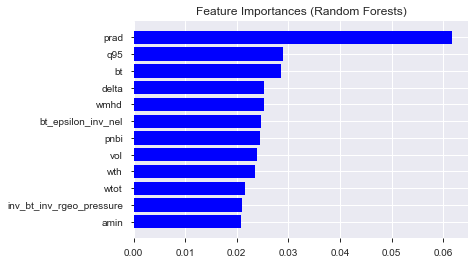

In [26]:
features = fourth_pass_columns
importances = cur_clf.feature_importances_
indices = reversed(np.argsort(importances))

count = 0
new_indices = []
names = []
for index in indices:
    if len(new_indices) >= 12 : break
        
    name = features[index]
    if name.startswith("_") : 
        new_indices.append(index)
        name = name.replace("abs_", "")[1:]
        names.append(name)
        continue
    name = name.replace("inv_", "")
    name = name.replace("log_", "")
    
    if name in names : continue
    names.append(name)
    
    new_indices.append(index)
  
indices = list(reversed(new_indices))
names = reversed(names)

plt.title('Feature Importances (Random Forests)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), names)
plt.xlabel('')
plt.show()

In [27]:
def plot_1(ax):
    plt.sca(ax)
    
    features = fourth_pass_columns
    importances = log_clf.best_estimator_.coef_[0][np.where(np.abs(log_clf.best_estimator_.coef_) > 1e-5)[1]]
    indices = reversed(np.argsort(np.abs(importances)))

    count = 0
    new_indices = []
    names = []
    for index in indices:
        if len(new_indices) >= 12 : break

        name = features[index]
        if name.startswith("_") : 
            new_indices.append(index)
            name = name.replace("abs_", "")[1:]
            names.append(name)
            continue
        name = name.replace("inv_", "")
        name = name.replace("log_", "")

        if name in names : continue
        names.append(name)

        new_indices.append(index)

    indices = list(reversed(new_indices))
    names = list(reversed(names))

    importances = importances[indices]
    indices = list(reversed(np.argsort((importances))))

    names = [names[i] for i in indices]

    # features = fourth_pass_columns
    # importances = log_clf.best_estimator_.coef_[0][np.where(np.abs(log_clf.best_estimator_.coef_) > 1e-5)[1]]
    # indices = reversed(np.argsort(np.abs(importances)))

    plt.title('Logistic Features')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), names)
    plt.xlabel('')

In [28]:
cur_X = cur_data[fourth_pass_columns]
cur_y = cur_data["is_good"]

scaler = StandardScaler().fit(cur_X)
cur_X = pd.DataFrame(scaler.transform(cur_X), columns=cur_X.columns)

tuned_parameters = {}
svc_clf = GridSearchCV(LinearSVC(C=10, penalty="l1", dual=False, max_iter=10000, verbose=True), tuned_parameters, cv=4)
svc_clf.fit(cur_X, cur_y)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LinearSVC(C=10, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l1',
                                 random_state=None, tol=0.0001, verbose=True),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [29]:
def plot_2(ax):
    plt.sca(ax)
    
    fifth_pass_columns = cur_X.columns[np.where(np.abs(svc_clf.best_estimator_.coef_) > 1e-5)[1]]

    features = fifth_pass_columns
    importances = svc_clf.best_estimator_.coef_[0][np.where(np.abs(svc_clf.best_estimator_.coef_) > 1e-5)[1]]
    indices = reversed(np.argsort(np.abs(importances)))

    count = 0
    new_indices = []
    names = []
    for index in indices:
        if len(new_indices) >= 12 : break

        name = features[index]
        if name.startswith("_") : 
            new_indices.append(index)
            name = name.replace("abs_", "")[1:]
            names.append(name)
            continue
        name = name.replace("inv_", "")
        name = name.replace("log_", "")

        if name in names : continue
        names.append(name)

        new_indices.append(index)

    indices = list(reversed(new_indices))
    names = list(reversed(names))

    importances = importances[indices]
    indices = list(reversed(np.argsort((importances))))

    names = [names[i] for i in indices]

    # features = fourth_pass_columns
    # importances = log_clf.best_estimator_.coef_[0][np.where(np.abs(log_clf.best_estimator_.coef_) > 1e-5)[1]]
    # indices = reversed(np.argsort(np.abs(importances)))

    plt.title('SVM Features')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), names)
    plt.xlabel('')


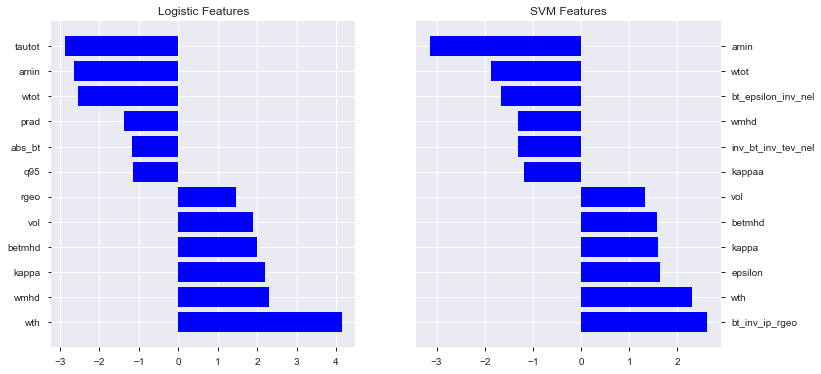

In [30]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
plot_1(ax)
ax = plt.subplot(1,2,2)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plot_2(ax)

In [31]:
list(fourth_pass_columns)

['_abs_bt_epsilon_inv_nel',
 '_abs_bt_inv_abs_ip_rgeo',
 '_imp_prad_tok_pbxm',
 '_inv_abs_bt_inv_rgeo_pressure',
 '_inv_abs_bt_inv_tev_nel',
 '_inv_abs_bt_nel',
 '_inv_abs_ip_rgeo_tev',
 'abs_pohm',
 'beili2',
 'betmhd',
 'bt',
 'delta',
 'epsilon',
 'greenwald',
 'imp_tauth',
 'inv_abs_bt',
 'inv_abs_ip',
 'inv_amin',
 'inv_betmhd',
 'inv_bt',
 'inv_greenwald',
 'inv_ip',
 'inv_kappa',
 'inv_meff',
 'inv_pl',
 'inv_q95',
 'inv_rgeo',
 'inv_tauth',
 'inv_tautot',
 'inv_tev',
 'inv_time',
 'inv_vol',
 'inv_wmhd',
 'inv_wth',
 'kappa',
 'log_betmhd',
 'log_inv_kappaa',
 'log_pl',
 'log_time',
 'log_wmhd',
 'meff',
 'pinj',
 'pl',
 'pnbi',
 'prad',
 'q95',
 'rgeo',
 'tauth',
 'tautot',
 'time',
 'wmhd',
 'wth',
 'wtot']